# Extract Structured Information from Case Texts
A sample of 10k files across different years and High Courts is used to create functions and processes to extract information. Helper functions are written in Pycharm and imported.

In [2]:
import os 
import sys
import re
import time
import csv
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import ik_parsing as ik
import data_extraction as de
import helper_functions as hp
import defs
from datetime import datetime
from collections import defaultdict
import itertools
import zipfile
import gzip
import json
import concurrent.futures
from multiprocessing import Pool
import matplotlib.pyplot as plt

head, tail = os.path.split(os.getcwd())

## 2. Extracting Structured Information from Case Text
Similar to what we did with the more structured Guwahati HC data, we now try to parse important information such as judge names, case types, names of litigants etc from the case text. It is incredibly hard due to different courts having different formats that also change with time.

Import a list of banks from a RBI linked website. This seems like an exhaustive list of ~160 banks in India.

### With Multiprocessing

In [12]:
import importlib
importlib.reload(ik)
importlib.reload(de)


if __name__ == '__main__':
    start = time.time()
#     courts = ['chennai', 'jharkhand', 'chattisgarh', 'jammu', 'andhra']
    courts = ['allahabad', 'gauhati']
#     courts = ['bangaloredc', 'gujarat', 'bombay', 'himachal_pradesh']
    dfs = []
#     pool = Pool()
#     results = pool.imap(de.extract_data, courts)      
                
    with concurrent.futures.ProcessPoolExecutor() as executor:
        results = executor.map(de.extract_data, courts)

    for result in results:
        dfs.append(pd.DataFrame(result))

df = pd.concat(dfs)

# takes ~1506 seconds with 500 limit break; took ~3 hours or so for all of MH, JH and CH
print(f"--- {(time.time() - start)} seconds ---")  

print(df.shape)
df.head()

--- 10259.80197095871 seconds ---
(294962, 14)


,file,cnr_num,title,date,court,case_number,petitioner,respondent,petitioner_advocate,respondent_advocate,judge,banks,cases_cited,acts_cited
0,allahabad/2000/1001747.txt,NaN,Vinay Kumar Jain And Ors. vs Official Liquidat...,2000-08-10,Allahabad High Court,NaN,NaN,NaN,NaN,NaN,{M Jain},"{'punjab national bank': 1, 'syndicate bank': 1}",{1305316},{846055}
1,allahabad/2000/1002196.txt,NaN,Pradeep Narain Sharma And Another vs Satya Pra...,2000-01-03,Allahabad High Court,NaN,NaN,NaN,NaN,NaN,{D Seth},NaN,"{1003154, 1889952, 679548, 1342750, 929224, 10...",{74337881}
2,allahabad/2000/1004466.txt,NaN,"Rakesh Agarwal vs Chairman, L.I.C. Of India An...",2000-09-27,Allahabad High Court,NaN,NaN,NaN,NaN,NaN,"{S Narain, K Kumar}",NaN,"{1352075, 1397061, 199012, 1270113, 357605, 94...",{}
3,allahabad/2000/1007120.txt,NaN,Sheetal Prasad Kesharwani vs Xvith Addl. Distr...,2000-05-25,Allahabad High Court,2. a release application. parwati tandon and o...,NaN,NaN,NaN,NaN,{A Yog},NaN,{1712542},"{463150, 1589017}"
4,allahabad/2000/10104.txt,NaN,Jagdish Prasad vs Passenger Tax Officer And Anr.,2000-02-02,Allahabad High Court,NaN,NaN,NaN,NaN,NaN,"{g. p. mathur, j. and regret my inability to a...",NaN,"{992009, 789969, 145572122, 8820, 175463, 2691...","{865156, 785258, 647421, 1907642, 946665, 9358..."


In [22]:
df.reset_index(drop=True, inplace=True)
df['case_id'] = df['file'].apply(lambda x: x[x.rfind('/')+1:-4]) 

citation_counts = hp.citation_count_dict(df)

df['times_cited'] = df['case_id'].apply(lambda x: citation_counts.get(x, 0))

df['bench_size'] = df.loc[:,'judge'].dropna().apply(len)
        
df['num_cases_cited'] = df.loc[:,'cases_cited'].dropna().apply(len)
df['num_acts_cited'] = df.loc[:,'acts_cited'].dropna().apply(len)

df['chief_justice'] = df.loc[:,'judge'].dropna().apply(lambda x: (any('chief' in item for item in x)))

keywords_state = ['state', 'government', 'commissioner', 'national', 'india', 'indian', 'public', 'magistrate',
                  'collector', 'department', 'district']
df['state'] = df.loc[:,'title'].dropna().apply(lambda x: (any(keyword in x.lower() for keyword in keywords_state)))

keywords_business = ['pvt', 'private', 'limited', 'ltd', 'company', 'co.', 'llp', 'llc']
df['business'] = (df.loc[:,'petitioner']+df.loc[:,'respondent']).dropna().apply(lambda x: (any(keyword in x.lower() for keyword in keywords_business)))

keywords_male = ['shri', 'mr.', 'master']

df.replace('\n', ' ', regex = True, inplace = True)
print(df.shape)
df.head()

(2715513, 21)


,file,cnr_num,title,date,court,case_number,petitioner,respondent,petitioner_advocate,respondent_advocate,...,banks,cases_cited,acts_cited,case_id,bench_size,num_cases_cited,num_acts_cited,chief_justice,state,business
0,chennai/2000/1001653.txt,NaN,Combined Engineering Industries ... vs Income ...,2000-11-06,Madras High Court,NaN,NaN,NaN,NaN,NaN,...,NaN,{1992728},"{1208169, 618701}",1001653,1.0,1,2,False,False,NaN
1,chennai/2000/1004399.txt,NaN,Arvind C' Bhagat vs Commissioner Of Customs,2000-06-29,Madras High Court,NaN,NaN,NaN,NaN,NaN,...,NaN,{},"{1059693, 1183072}",1004399,1.0,0,2,False,True,NaN
2,chennai/2000/1004986.txt,NaN,N. Palaniappan vs Government Of Tamil Nadu And...,2000-07-10,Madras High Court,NaN,NaN,NaN,NaN,NaN,...,NaN,{1712542},{},1004986,1.0,1,0,False,True,NaN
3,chennai/2000/100594719.txt,NaN,C.Varghees Nadar (Died) vs V.Kamalakshi,2000-04-17,Madras High Court,NaN,NaN,NaN,NaN,NaN,...,NaN,"{599955, 515323}","{112509054, 561156, 1768154, 1700171, 515580}",100594719,1.0,2,5,False,False,NaN
4,chennai/2000/1006026.txt,NaN,"Sounder Rajan vs Junior Engineer, Tamil Nadu ...",2000-03-01,Madras High Court,NaN,NaN,NaN,NaN,NaN,...,NaN,{1712542},{},1006026,1.0,1,0,False,False,NaN


In [189]:
df.isna().sum()

file                        0
cnr_num                915071
title                    7160
date                     7160
court                    7160
case_number            755349
petitioner             461283
respondent             461283
petitioner_advocate    891544
respondent_advocate    913377
judge                   38775
banks                  946423
citations              190582
bench_size              38775
num_citations          190582
chief_justice           38775
state                    7160
business               461283
case_id                     0
times_cited                 0
dtype: int64

The number of missing values. Try and get this to around 85-90% and above to proceed. Judges we are extracting at a reasonable accuracy. Next step is to optimize advocates but that is a lot more difficult. Will have to try NER or other approaches. 

We have parsed all the basic case data into the dataframe. Pickle it so that you dont need to run above code every time you start this notebook. Instead you can start from below on. 

In [32]:
df.to_pickle('df_allcourts.pkl')

In [14]:
df = pd.read_pickle('df_5courts.pkl')

In [33]:
print(df.shape)
df = df[df.court!='Gujarat High Court']
print(df.shape)

(2715513, 22)
(1652183, 22)


In [34]:
print(df.court.value_counts())

Madras High Court              470761
Jharkhand High Court           338969
Allahabad High Court           228124
Bombay High Court              221571
Himachal Pradesh High Court    131476
Bangalore District Court        67788
Gauhati High Court              64640
Chattisgarh High Court          59361
Jammu & Kashmir High Court      36713
Andhra High Court               14263
Name: court, dtype: int64


In [35]:
df.groupby(df.date.dt.strftime('%Y')).size()

date
2000      3955
2001      4849
2002      8769
2003      8852
2004      8834
2005      8709
2006     12366
2007     12582
2008      9966
2009     12191
2010     83620
2011     45764
2012     49289
2013     39700
2014     67325
2015    155688
2016    146459
2017    203641
2018    282016
2019    469091
dtype: int64

In [42]:
df.loc[(df['date'] >= '2000-1-1') & (df['date'] <= '2001-1-1'),'cases_cited'] #.isna().sum()

0                                                  {1992728}
1                                                         {}
2                                                  {1712542}
3                                           {599955, 515323}
4                                                  {1712542}
                                 ...                        
2650678    {1750229, 1123043, 26873, 1528935, 1834398, 13...
2650679                            {1712542, 195765, 367586}
2650680    {1208473, 3425, 80056, 1421992, 1115931, 1472641}
2650681           {211089, 1111529, 882644, 250697, 1466728}
2650682                           {1569580, 1569253, 116141}
Name: cases_cited, Length: 3957, dtype: object

In [43]:
pd.pivot_table(df, values='num_cases_cited', index='court', columns=df.date.dt.strftime('%Y'), aggfunc=np.size) #.to_csv('table1.csv')

date,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
court,,,,,,,,,,,,,,,,,,,,
Allahabad High Court,792.0,26.0,1380.0,1448.0,2044.0,2308.0,2023.0,1763.0,395.0,NaN,70710.0,9595.0,8909.0,10209.0,13182.0,8321.0,10406.0,10757.0,7048.0,66808.0
Andhra High Court,892.0,1492.0,1362.0,1282.0,1255.0,1077.0,1267.0,1028.0,185.0,NaN,1.0,11.0,469.0,477.0,1141.0,671.0,528.0,687.0,438.0,NaN
Bangalore District Court,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42295.0,1740.0,6718.0,9664.0,7371.0
Bombay High Court,924.0,973.0,1343.0,1283.0,1417.0,1508.0,1233.0,1334.0,1418.0,2042.0,1923.0,1903.0,2119.0,2026.0,1775.0,2296.0,9424.0,12255.0,52539.0,121836.0
Chattisgarh High Court,15.0,101.0,92.0,64.0,68.0,139.0,178.0,228.0,196.0,362.0,520.0,446.0,321.0,NaN,5.0,7825.0,13047.0,13258.0,12354.0,10142.0
Gauhati High Court,239.0,320.0,346.0,544.0,401.0,343.0,499.0,549.0,81.0,NaN,38.0,300.0,494.0,423.0,666.0,1047.0,930.0,1607.0,4512.0,51301.0
Himachal Pradesh High Court,53.0,76.0,104.0,68.0,83.0,194.0,196.0,270.0,41.0,NaN,NaN,NaN,NaN,NaN,NaN,5677.0,NaN,16772.0,54062.0,53880.0
Jammu & Kashmir High Court,112.0,59.0,169.0,334.0,346.0,307.0,259.0,170.0,54.0,75.0,110.0,111.0,265.0,403.0,270.0,203.0,410.0,6140.0,3751.0,23165.0
Jharkhand High Court,39.0,687.0,1072.0,1211.0,966.0,739.0,1106.0,759.0,823.0,2702.0,1938.0,25965.0,28390.0,20221.0,29721.0,34741.0,44777.0,57177.0,49682.0,36253.0


In [44]:
month_year_group = df.groupby(df.date.dt.strftime('%B-%Y'))

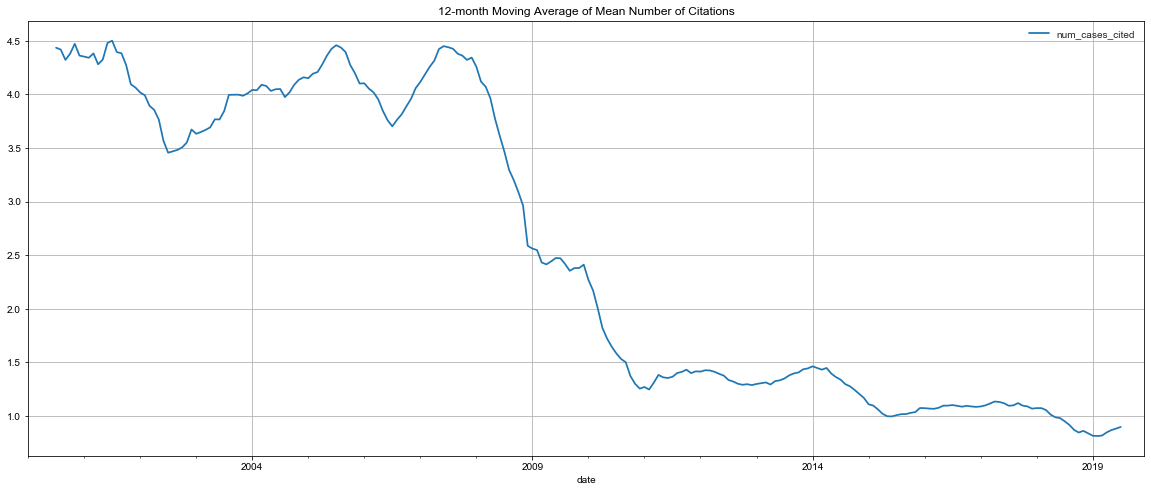

In [45]:
fig, ax = plt.subplots()
plt.style.use('seaborn')
mean_citations_monthly = pd.DataFrame(month_year_group['num_cases_cited'].mean())
mean_citations_monthly.index = pd.to_datetime(mean_citations_monthly.index) 
mean_citations_monthly.sort_index(inplace=True) 
mean_citations_monthly.rolling(12, center=True).mean().plot(figsize=(20,8), ax=ax, title='12-month Moving Average of Mean Number of Citations')

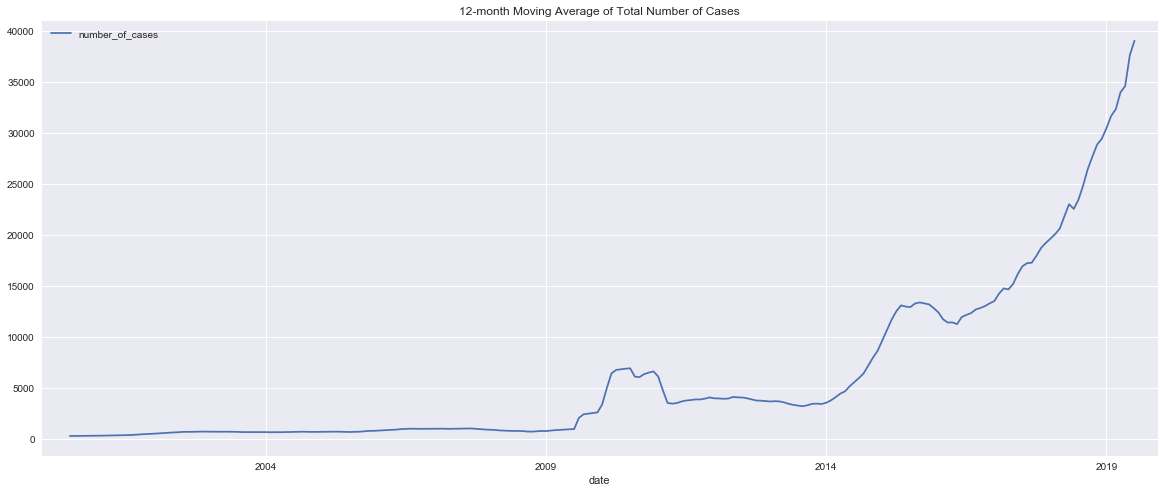

In [46]:
fig, ax = plt.subplots()
plt.style.use('seaborn')
cases_by_time = pd.DataFrame(month_year_group.size())
cases_by_time.index = pd.to_datetime(cases_by_time.index)
cases_by_time.sort_index(inplace=True) 
cases_by_time.columns = ['number_of_cases']
cases_by_time.rolling(12, center=True).mean().plot(figsize=(20,8), ax=ax, title='12-month Moving Average of Total Number of Cases')
# cases_by_time.plot(figsize=(20,8))

Text(0, 0.5, 'Mean Number of Citations per Case by Year')

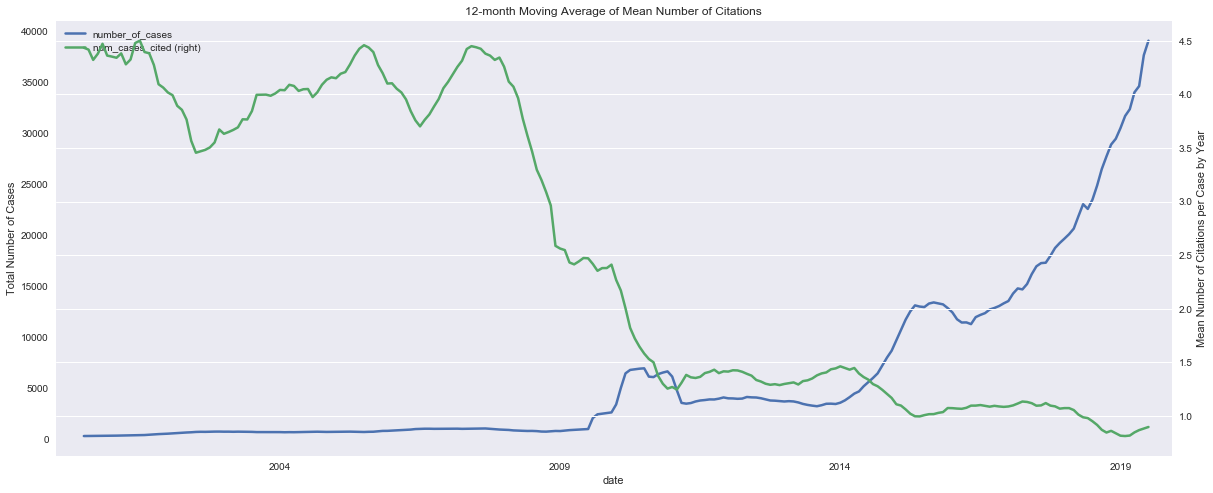

In [47]:
fig, ax = plt.subplots()
plt.style.use('seaborn')

cases_by_time.rolling(12, center=True).mean().plot(figsize=(20,8), linewidth=2.5, ax=ax, title='12-month Moving Average of Total Number of Cases')
ax.set_ylabel("Total Number of Cases")

mean_citations_monthly.rolling(12, center=True).mean().plot(figsize=(20,8), linewidth=2.5, secondary_y=True, ax=ax, title='12-month Moving Average of Mean Number of Citations')
plt.ylabel("Mean Number of Citations per Case by Year")

Text(0, 0.5, 'Mean number of citations per case')

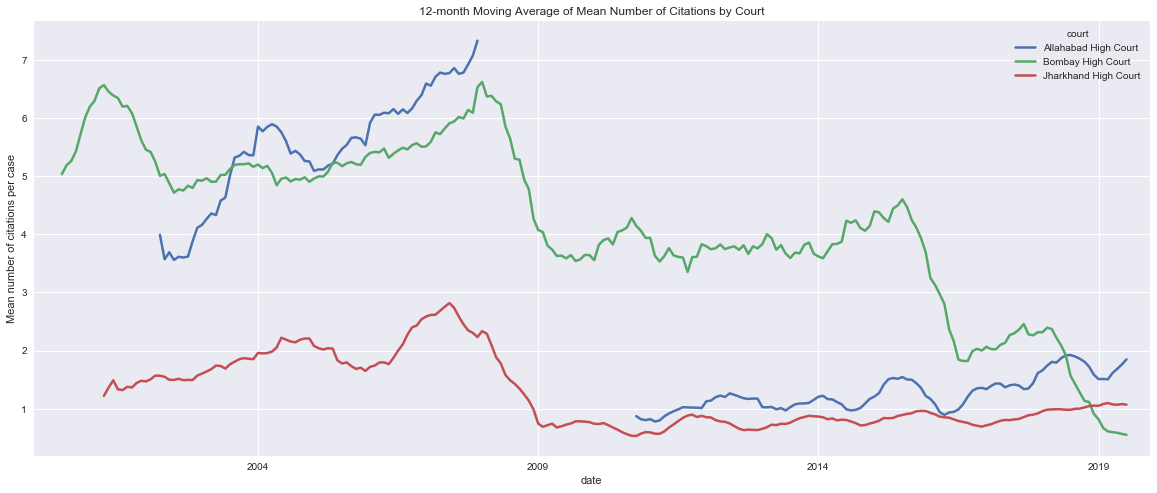

In [48]:
fig, ax = plt.subplots()
plt.style.use('seaborn')

citations_by_court_year = df[(df.court== 'Bombay High Court')|(df.court=='Jharkhand High Court')|(df.court=='Allahabad High Court')]
citations_by_court_year.index = pd.to_datetime(citations_by_court_year.date.dt.strftime('%B-%Y'), format='%B-%Y')
citations_by_court_year = citations_by_court_year.pivot_table(index = citations_by_court_year.index,columns='court',values='num_cases_cited',aggfunc='mean')
citations_by_court_year = citations_by_court_year.rolling(12, center=True).mean()
citations_by_court_year.plot(figsize=(20,8), linewidth=2.5, ax=ax, title='12-month Moving Average of Mean Number of Citations by Court')
plt.ylabel("Mean number of citations per case")

Text(0, 0.5, 'Total Number of Cases')

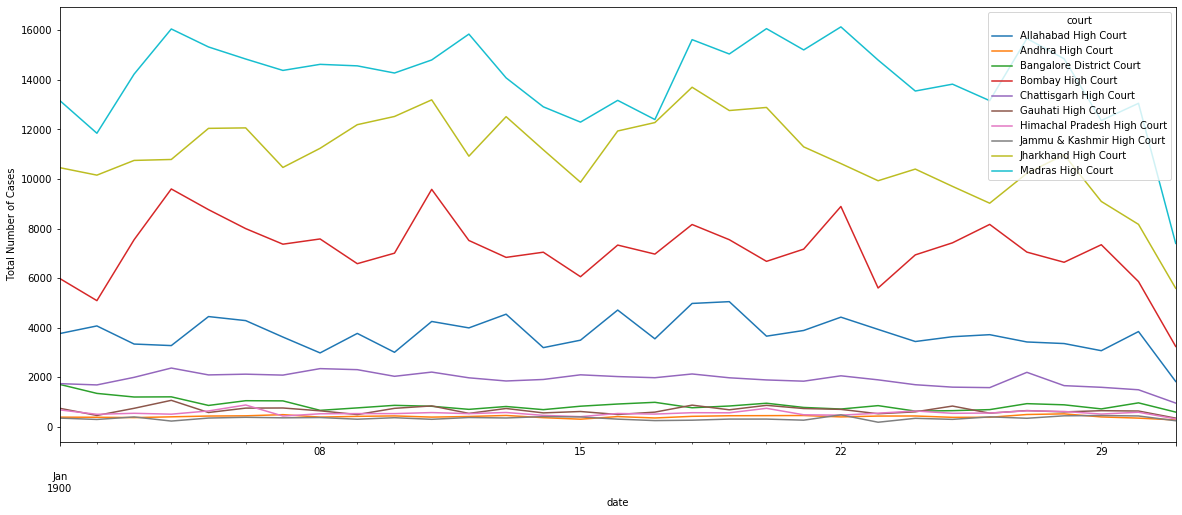

In [41]:
cases_by_court_year = df #[(df.court=='Bombay High Court')|(df.court=='Jharkhand High Court')|(df.court=='Allahabad High Court')]
cases_by_court_year.index = pd.to_datetime(cases_by_court_year.date.dt.strftime('%d'), format='%d')
plot3 = cases_by_court_year.pivot_table(index = cases_by_court_year.index,columns='court',values='num_citations',aggfunc='count').plot(figsize=(20,8))
plot3.set_ylabel("Total Number of Cases")

In [16]:
from textdistance import smith_waterman, needleman_wunsch, jaro_winkler, jaccard, levenshtein

judges_dict = defaultdict(int)
for judge_set in df['judge']:
    if str(judge_set)!='nan':
        for judge in judge_set:
            judges_dict[judge] += 1

In [17]:
print(len(judges_dict))        

for judge_pair in itertools.combinations(judges_dict, 2):
    score = jaccard.normalized_similarity(judge_pair[0], judge_pair[1])
    if score>0.95:
        carryover = judges_dict.pop(judge_pair[1], 0)
        judges_dict[judge_pair[0]] += carryover

print(len(judges_dict))

15415
13784


15415 entries trimmed to 13784 judges after merging similar key values above.

## Forward Citations
I think cases after 2009 were uploaded as they were put up online by the courts as Sushant I believe said he had a daily crawler. In that case we do not have a pre period to compare the pre vs post putting the case up on IK. What we could do instead is to check the pre vs post for cases before 2009 when IK did not exist. For these older cases we can check their average citations before IK and then after to see if there exists any jump. However, the problem here is the very small number of cases we have for years before 2009. 

In [138]:
pre2009cases = df[df.date.dt.year<2009].case_id.to_list()

for case in pre2009cases:
    for row in df.itertuples():
        print(row)
        break
    break

Pandas(Index=Timestamp('1900-01-16 00:00:00'), file='bombay/2000/1001219.txt', cnr_num=nan, title='Smt. Kamalabai Baburao Kabade vs Smt. Laxmibai Janardan Jagtap And ...', date=Timestamp('2000-06-16 00:00:00'), court='Bombay High Court', case_number=nan, petitioner=nan, respondent=nan, petitioner_advocate=nan, respondent_advocate=nan, judge={'A Khanwilkar'}, banks=nan, citations={'1331149', '135316600', '1108515', '26690152', '1630779', '1412634', '173132957'}, bench_size=1.0, num_citations=7.0, chief_justice=False, state=False, business=nan, case_id='1001219', times_cited=6)


In [73]:
sum(citation_counts.values())

1137181

## Citation Diversity

In [1]:
def citation_diversity(df):
    hhi_indices = []
    for year in range(2000, 2020):
        for month in range(1,13):
            citation_counts_year = list(hp.citation_count_dict(df.loc[(df.date.dt.year==year)&(df.date.dt.month==month), :]).values())
#             print((sorted(citation_counts_year, reverse=True)[:10]), sum(citation_counts_year))
            array_p_i = np.array(citation_counts_year)/sum(citation_counts_year)
            hhi = array_p_i * array_p_i * 10000
            hhi_indices.append(sum(hhi))
    return pd.DataFrame({'date': pd.date_range(start='2000/1/1', end='2019/12/1', freq='MS'), 'citation_diversity_index': hhi_indices})

citation_diversity_bombay = citation_diversity(df.loc[df.court=='Bombay High Court', :]) 
citation_diversity_bombay.set_index('date', inplace=True)
citation_diversity_bombay = citation_diversity_bombay.rolling(12, center=True).mean()
citation_diversity_bombay

NameError: name 'df' is not defined

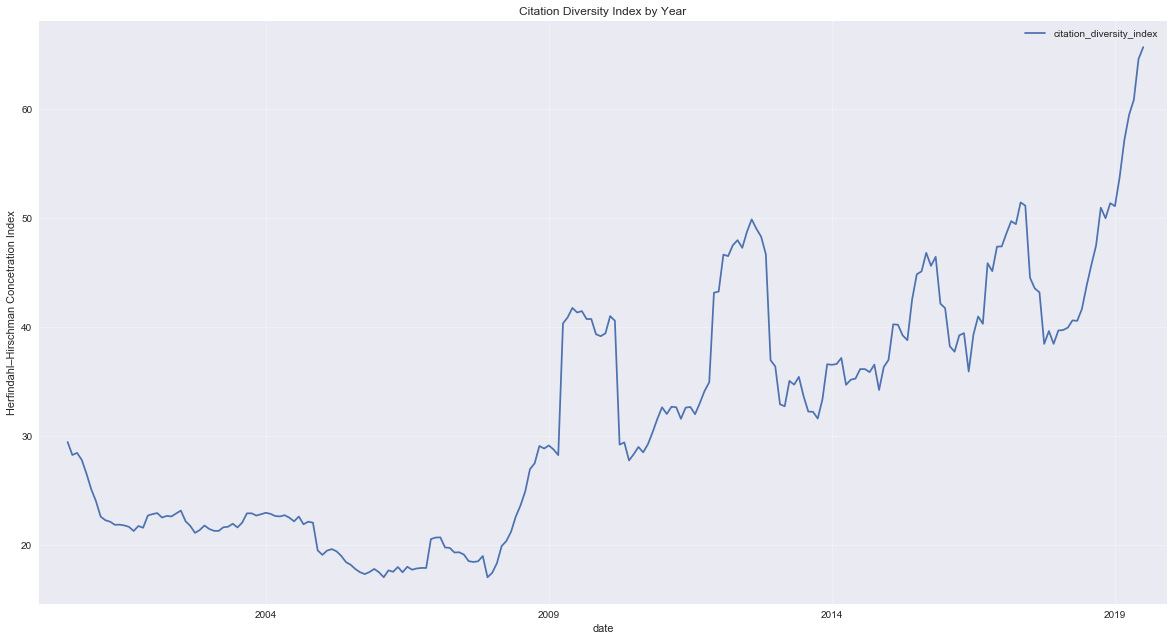

In [136]:
citation_diversity_bombay.index = pd.to_datetime(citation_diversity_bombay.index, format='%B-%Y')
fig, ax = plt.subplots()
citation_diversity_bombay.plot(figsize=(18,10), ax=ax, title='Citation Diversity Index by Year')
ax.set_ylabel('Herfindahl–Hirschman Concetration Index')
plt.grid(alpha=0.3)
plt.savefig('plot.png')

In [283]:
a = np.array([1, 3, 7, np.NaN])
np.sum(a)

nan

In [10]:

#df.groupby(
# df[df.date>"2000-01-01"] #.date.dt.strftime('%Y'))['num_citations'].mean()
sys.getsizeof(df)

4122469801

In [123]:
pd.date_range(start='2000/1/1', end='2019/12/1', freq='MS')

DatetimeIndex(['2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01',
               '2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01',
               '2000-09-01', '2000-10-01',
               ...
               '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01',
               '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', length=240, freq='MS')

In [31]:
df.describe()

,bench_size,num_cases_cited,num_acts_cited,times_cited
count,2.606250e+06,2.715513e+06,2.715513e+06,2.715513e+06
mean,1.189193e+00,8.663203e-01,6.180652e-01,4.207603e-02
std,5.245752e-01,2.766132e+00,1.795474e+00,2.456692e+00
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
max,9.500000e+01,2.110000e+02,9.600000e+01,1.920000e+03
